# M1. Actividad

**Nombre:** Diego Antonio García Padilla.

**Matrícula:** A01710777.

## Descripción del Sistema de 'Recolección de Alimentos'

### Objetivo del Sistema

Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

### Características del Sistema:

- **Energía del Explorador:** Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.
- **Ubicación de la Base:** La base siempre se encuentra en el centro del área de búsqueda.
- **Parámetros del Sistema:**
  - Un área de NxN celdas.
  - Un número específico de exploradores.
  - Una base fija en una celda determinada.
  - Un número de recursos.
  - Un máximo de energía que los exploradores pueden tener.

### Distribución de Agentes y Recursos:

- Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.

### Comportamiento por Paso:

- Si la celda contiene recursos, el agente los recoge y regresa a la base.
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.

## Instrucciones para la Simulación y el Análisis:

### Simulación Inicial:

- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.
- Todos los agentes deben empezar con 100 unidades de energía.
- Muestra gráficamente el comportamiento del modelo.

### Análisis de Eficiencia:

- Analiza cómo la cantidad de exploradores y recursos influye en la eficiencia de la recolección de recursos.
- La eficiencia se medirá observando la cantidad de energía que cada explorador consume durante el proceso de búsqueda y recolección de recursos.
- Para ello, realiza pruebas en un espacio de 15x15 con:
  - 5 y 10 exploradores.
  - 15, 20 y 30 recursos.
- Presenta los hallazgos en el informe, incluyendo gráficos y tablas según sea necesario.

# Instalación e importación de librerías

In [1]:
# Descargar mesa y seaborn
%pip install mesa seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete seaborn para mejorar la visualización de los datos.
import seaborn as sns

# Solución

- Los agentes se mueven al azar.
- Cuando encuentran comida, buscan el camino a la base.
- Si tienen menos de 20 de energía, regresan a la base.

## Definición de clases de Agente y Modelo

In [3]:
class ExplorerAgent(Agent):
    """
    Agente que recolecta comida.
    """

    def __init__(self, id, model, max_energy):
        """
        Constructor de la clase Explorer.
        """

        # Inicializamos la clase padre Agent
        super().__init__(id, model)

        # Atributos del agente
        self.model = model

        # Atributo para guardar la energía máxima del agente
        self.max_energy = max_energy

        # Atributo para guardar la energía del agente
        self.energy = max_energy

        # Atributo para saber si el agente tiene comida
        self.hasFood = False

        # Contador de comida recolectada
        self.foodFound = 0

        # Lista para guardar la eficiencia (cuánta energía gastó en recolectar comida)
        self.efficiency = []

        # Umbral de energía para regresar a la base
        self.energy_threshold = 20  

        # Energía usada en encontrar comida
        self.energy_search = 0
        

    def move(self):
        """
        Método que define el comportamiento del agente.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Recorrer las celdas vecinas
        for i in indexes:
            (x, y) = possible_steps[i]

            # Si la celda está vacía, moverse a ella
            if self.model.grid.is_cell_empty((x, y)):

                # Mover al agente
                self.model.grid.move_agent(self, (x, y))

                # Actualizar la energía
                self.energy -= 1

                # Actualizar la energía usada en encontrar comida
                self.energy_search += 1

                break

    def move_to_base(self):
        """
        Método que mueve al agente a la base.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener posición de la base
        (base_x, base_y) = self.model.base

        # Obtener posición actual del agente
        (x, y) = self.pos

        # Calcular la dirección en la que se moverá el agente
        dx = abs(base_x - x)
        dy = abs(base_y - y)

        # Determinar siguiente posición
        if dx >= dy:
            # Moverse en X
            next_x = x + (1 if base_x > x else -1)
            next_y = y
        else:
            # Moverse en Y
            next_x = x
            next_y = y + (1 if base_y > y else -1)

        # Verificar si la celda a la que se moverá el agente está vacía
        if self.model.grid.is_cell_empty((next_x, next_y)):

            # Mover al agente
            self.model.grid.move_agent(self, (next_x, next_y))

            # Actualizar la energía
            self.energy -= 1

            # Actualizar la energía usada en encontrar comida
            self.energy_search += 1
        
    
    def step(self):
        """
        Paso de simulación para el agente.
        """

        # Comprobar si tiene energía
        if self.energy == 0:
            return

        # Obtener la posición actual del agente
        (x, y) = self.pos

        # ¿El agente está en la base?
        if self.model.cells[x][y] == 2:

            # Si el agente tiene comida, dejarla en la base
            if self.hasFood:
                self.hasFood = False
                self.foodFound += 1
                self.model.food += 1

                # Guardar la eficiencia
                self.efficiency.append(self.max_energy - self.energy_search)

                # Recargar energía
                self.energy = self.max_energy

                # Reiniciar la energía usada en encontrar comida
                self.energy_search = 0

                # Mover al agente
                self.move()

            else:
                # Recargar energía
                self.energy = self.max_energy
                self.move()
        else:
            # Determinar si debe regresar a la base por baja energía
            if self.energy <= self.energy_threshold:
                self.move_to_base()
            # Si el agente tiene comida, moverse a la base
            elif self.hasFood:
                self.move_to_base()
            else:
                # Comprobar si hay comida en la celda actual
                if self.model.cells[x][y] == 1:
                    # Recolectar la comida
                    self.model.cells[x][y] = 0
                    self.hasFood = True
                    self.move_to_base()
                else:
                    self.move()

In [4]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 3
    return grid

In [5]:
class WorldModel(Model):
    """
    Modelo del mundo donde los agentes recolectan comida.
    """

    def __init__(self, width = 11, height = 11, num_agents = 5, agents_energy = 100, num_food = 20):
        """
        Constructor de la clase World.
        """

        # Inicializamos la clase padre Model
        super().__init__()

        # Pasos de la simulación
        self.steps = 0

        # Comida recolectada
        self.food = 0

        # Cantidad de comida en el mundo
        self.num_food = 0

        # Grid de la simulación
        self.grid = SingleGrid(width, height, torus = False)

        # Método de activación de los agentes
        self.schedule = SimultaneousActivation(self)

        # Ubicación de la base
        self.base = (width // 2, height // 2)

        # Inicializar celdas
        self.cells = np.zeros((width, height))

        # Agregar comida al mundo
        for _ in range(num_food):

            # Posición aleatoria
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)

            # Comprobar si la celda está vacía
            if self.cells[x][y] == 0:

                # Agregar comida
                self.cells[x][y] = 1

                # Actualizar cantidad de comida
                self.num_food += 1

        # Agregar agentes al mundo
        for i in range(num_agents):
            agent = ExplorerAgent(i, self, agents_energy)
            self.schedule.add(agent)
            self.grid.move_to_empty(agent)
        
        # Definir base
        self.cells[self.base[0]][self.base[1]] = 2

        # Recolectar datos
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Steps": lambda m: m.steps,
                "Food": lambda m: m.food,
                },
            agent_reporters = {
                "Efficiency": lambda a: sum(a.efficiency) / len(a.efficiency) if len(a.efficiency) > 0 else 0,
                "FoodFound": lambda a: a.foodFound
                }
        )

    def are_food(self):
        """
        Método que verifica si ya se ha recolectado toda la comida.
        """

        # ¿Se ha recolectado toda la comida?
        are_food = self.food < self.num_food

        return are_food
    
    def are_agents_alive(self):
        """
        Método que verifica si hay agentes vivos en el mundo.
        """

        # ¿Hay agentes con energía?
        are_agents_alive = sum(agent.energy > 0 for agent in self.schedule.agents) > 0

        return are_agents_alive
    
    def game_over(self):
        """
        Método que verifica si la simulación ha terminado.
        """

        # ¿No hay agentes vivos o comida en el mundo?
        return not self.are_agents_alive() or not self.are_food()
    
    def step(self):
        """
        Método que define el comportamiento de los agentes en un paso de la simulación.
        """

        # Comprobar que hay agentes vivos y comida en el mundo
        if not self.game_over():
            self.steps += 1
        
        # Recolectar datos
        self.datacollector.collect(self)

        # Activar a los agentes
        self.schedule.step()

## Simulación

In [6]:
X, Y = 11, 11
AGENTS = 5
AGENTS_ENERGY = 100
FOOD = 20

# Inicializar el modelo
model = WorldModel(X, Y, AGENTS, AGENTS_ENERGY, FOOD)

# Ejecutar el modelo
while not model.game_over():
    model.step()

print("Modelo terminado en", model.steps, "pasos")
print("Comida recolectada:", model.food / model.num_food * 100, "%")

Modelo terminado en 244 pasos
Comida recolectada: 100.0 %


In [7]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps,Food
0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,0
1,"[[0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5,1


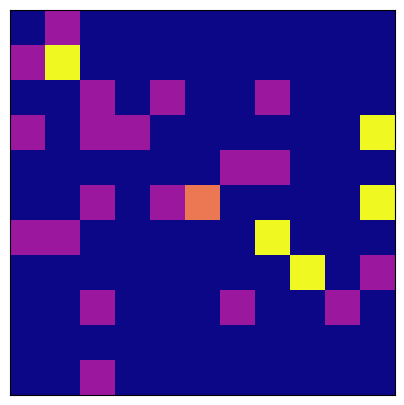

In [8]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.plasma)

def animate(i):
  patch.set_data(all_grids.iloc[i,0])


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False)

In [9]:
anim

# Análisis

In [10]:
# Parámetros de la simulación
MAX_STEPS = 300
ITERATIONS = 5

## Caso 1

- Espacio 15 x 15
- 5 exploradores
- 15 recursos

In [11]:
params_1 = {
    "width": 15,
    "height": 15,
    "num_agents": 5,
    "num_food": 15
}

results_1 = batch_run(
    WorldModel,
    parameters = params_1,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
df_1 = pd.DataFrame(results_1)
data_1 = df_1[(df_1.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [13]:
data_1.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
1500,0,0,301,12,0,0.0,0
1501,0,0,301,12,1,72.5,4
1502,0,0,301,12,2,-163.0,1
1503,0,0,301,12,3,41.0,2
1504,0,0,301,12,4,79.6,5


In [14]:
data_1.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                  
          min   mean  max       min mean max        min       mean    max
AgentID                                                                  
0         301  301.0  301         0  2.0   4      -65.0  26.650000  82.50
1         301  301.0  301         0  3.0   5      -36.0  29.350000  72.50
2         301  301.0  301         0  1.2   2     -163.0 -11.300000  84.00
3         301  301.0  301         2  2.8   4      -20.0  32.200000  81.50
4         301  301.0  301         0  2.6   5        0.0  56.203333  85.75

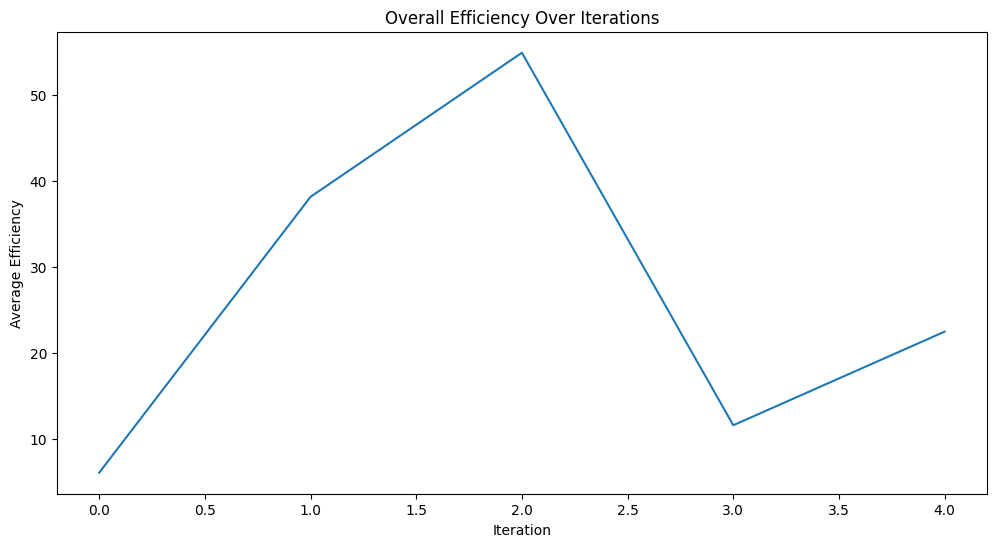

In [15]:
grouped_1 = data_1.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_1)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 2

- Espacio 15 x 15
- 5 exploradores
- 20 recursos

In [16]:
params_2 = {
    "width": 15,
    "height": 15,
    "num_agents": 5,
    "num_food": 20
}

results_2 = batch_run(
    WorldModel,
    parameters = params_2,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
df_2 = pd.DataFrame(results_2)
data_2 = df_2[(df_2.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [18]:
data_2.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
1500,0,0,301,11,0,61.000000,5
1501,0,0,301,11,1,0.000000,0
1502,0,0,301,11,2,65.500000,2
1503,0,0,301,11,3,57.000000,1
1504,0,0,301,11,4,12.333333,3


In [19]:
data_2.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         301  301.0  301         2  4.0   5       41.0  55.450000  77.500000
1         301  301.0  301         0  3.0   7        0.0  44.857143  81.285714
2         301  301.0  301         1  3.6   9     -132.0  31.216667  85.500000
3         301  301.0  301         0  1.8   4     -170.0  -3.300000  69.000000
4         301  301.0  301         0  2.8   5        0.0  38.506667  66.200000

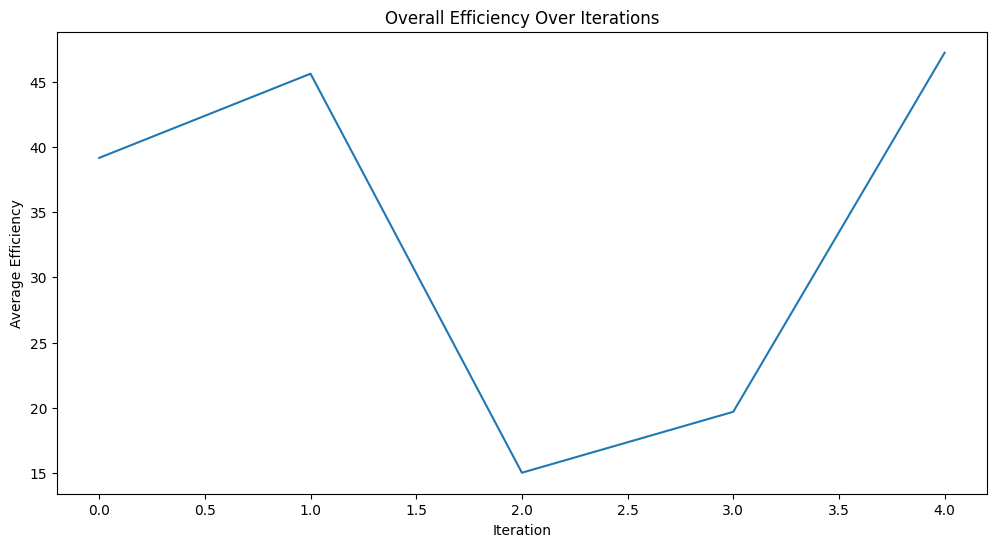

In [20]:
grouped_2 = data_2.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_2)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 3

- Espacio 15 x 15
- 5 exploradores
- 30 recursos

In [21]:
params_3 = {
    "width": 15,
    "height": 15,
    "num_agents": 5,
    "num_food": 30
}

results_3 = batch_run(
    WorldModel,
    parameters = params_3,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
df_3 = pd.DataFrame(results_3)
data_3 = df_3[(df_1.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [23]:
data_3.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
1500,0,0,301,18,0,43.200000,5
1501,0,0,301,18,1,68.500000,2
1502,0,0,301,18,2,0.000000,0
1503,0,0,301,18,3,73.833333,6
1504,0,0,301,18,4,72.000000,5


In [24]:
data_3.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         301  301.0  301         3  5.0   7      38.75  55.180476  72.000000
1         301  301.0  301         2  4.2   5      60.00  66.960000  72.500000
2         301  301.0  301         0  3.4   6       0.00  48.273333  67.200000
3         301  301.0  301         4  4.8   6      46.40  63.326667  80.000000
4         301  301.0  301         3  3.4   5      25.00  59.533333  90.333333

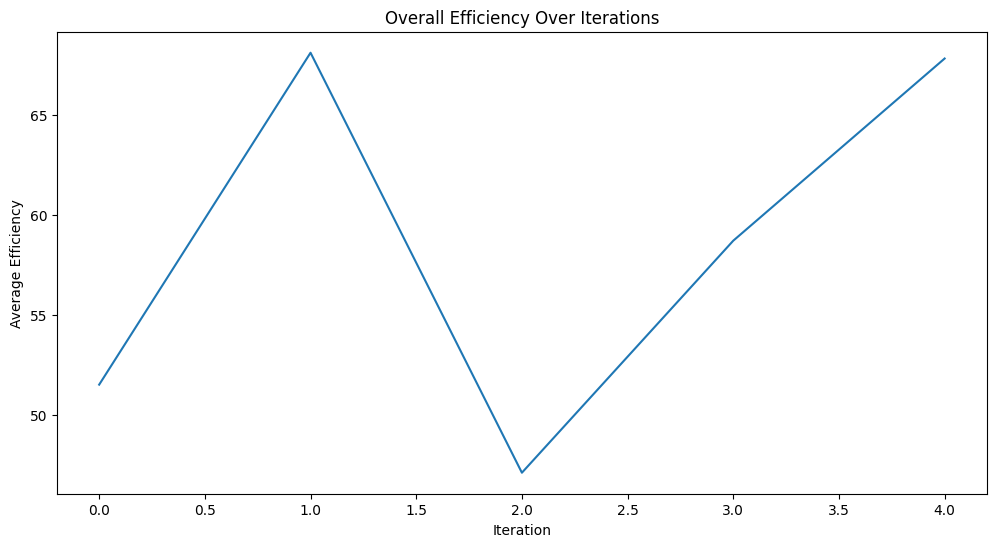

In [25]:
grouped_3 = data_3.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_3)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 4

- Espacio 15 x 15
- 10 exploradores
- 15 recursos

In [26]:
params_4 = {
    "width": 15,
    "height": 15,
    "num_agents": 10,
    "num_food": 15
}

results_4 = batch_run(
    WorldModel,
    parameters = params_4,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
df_4 = pd.DataFrame(results_4)
data_4 = df_4[(df_4.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [28]:
data_4.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
3000,0,0,301,14,0,0.0,0
3001,0,0,301,14,1,22.0,1
3002,0,0,301,14,2,-37.5,2
3003,0,0,301,14,3,64.0,1
3004,0,0,301,14,4,19.5,2


In [29]:
data_4.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                 
          min   mean  max       min mean max        min       mean   max
AgentID                                                                 
0         173  260.0  301         0  1.4   4        0.0  36.000000  69.0
1         173  260.0  301         0  1.2   3        0.0  50.933333  88.0
2         173  260.0  301         0  1.8   3      -37.5  16.500000  64.5
3         173  260.0  301         1  1.6   2       -8.5  53.000000  83.0
4         173  260.0  301         0  2.0   5      -70.0  21.720000  88.5
5         173  260.0  301         0  1.2   3        0.0  31.700000  89.5
6         173  260.0  301         0  1.0   2        0.0  46.400000  83.0
7         173  260.0  301         0  1.4   3        0.0  47.933333  96.0
8         173  260.0  301         0  1.2   3        0.0  54.400000  89.0
9         173  260.0  301         0  1.0   3        0.0  30.700000  87.0

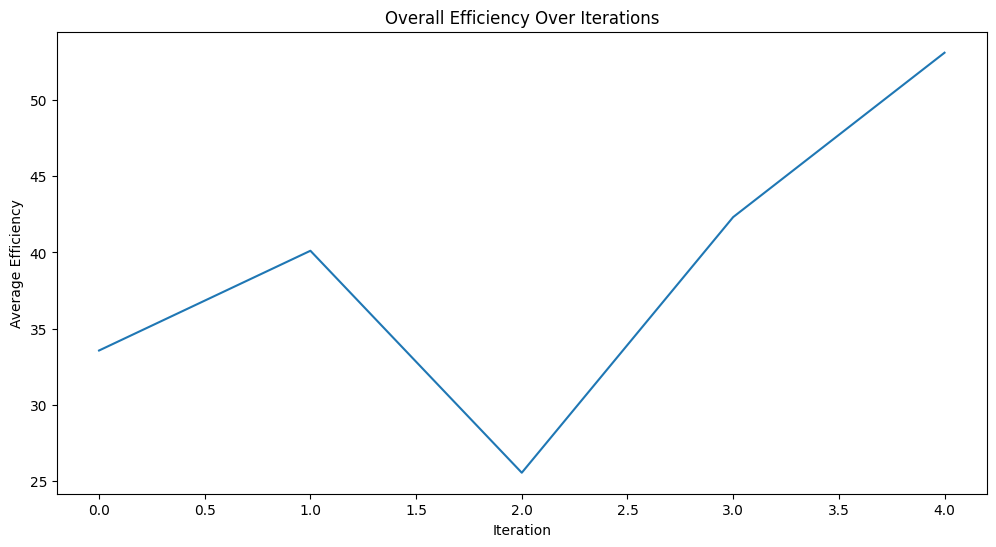

In [30]:
grouped_4 = data_4.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_4)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 5

- Espacio 15 x 15
- 10 exploradores
- 20 recursos

In [31]:
params_5 = {
    "width": 15,
    "height": 15,
    "num_agents": 10,
    "num_food": 20
}

results_5 = batch_run(
    WorldModel,
    parameters = params_5,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
df_5 = pd.DataFrame(results_5)
data_5 = df_5[(df_4.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [33]:
data_5.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
3000,0,0,301,19,0,-74.000000,1
3001,0,0,301,19,1,78.666667,3
3002,0,0,301,19,2,39.000000,1
3003,0,0,301,19,3,84.000000,2
3004,0,0,301,19,4,68.500000,2


In [34]:
data_5.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                 
          min   mean  max       min mean max        min       mean   max
AgentID                                                                 
0         168  274.4  301         0  1.2   2      -74.0  17.800000  76.0
1         168  274.4  301         1  2.0   3       71.0  81.333333  91.0
2         168  274.4  301         1  1.8   4       39.0  62.000000  81.0
3         168  274.4  301         1  1.8   3      -50.0  17.366667  84.0
4         168  274.4  301         1  2.0   3       23.0  68.300000  92.0
5         168  274.4  301         0  1.4   2        0.0  64.700000  88.0
6         168  274.4  301         0  1.4   3      -18.0  43.200000  89.0
7         168  274.4  301         1  2.0   3      -29.0  46.266667  80.0
8         168  274.4  301         0  2.0   4      -12.5  23.800000  73.5
9         168  274.4  301         1  1.8   3       33.0  68.600000  90.0

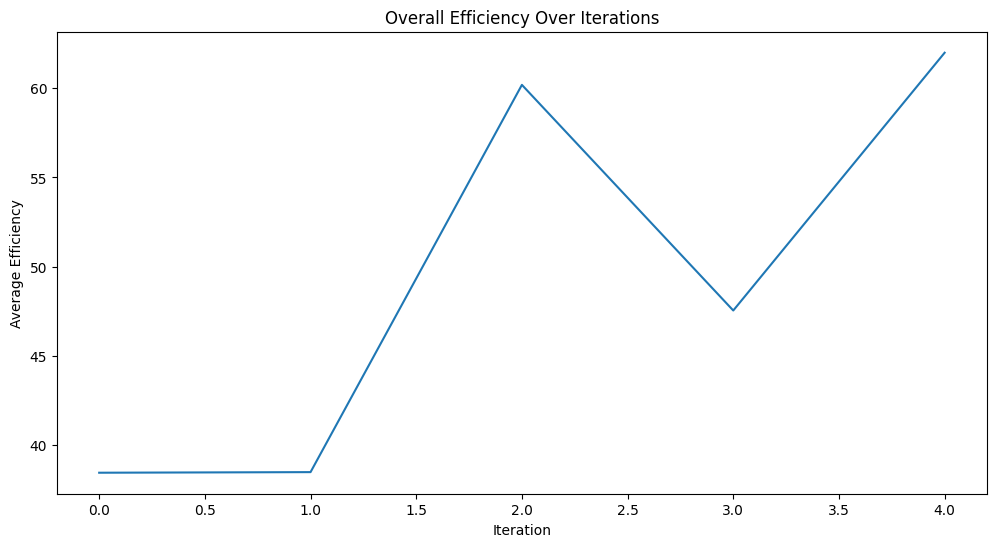

In [35]:
grouped_5 = data_5.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_5)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 6

- Espacio 15 x 15
- 10 exploradores
- 30 recursos

In [36]:
params_6 = {
    "width": 15,
    "height": 15,
    "num_agents": 10,
    "num_food": 30
}

results_6 = batch_run(
    WorldModel,
    parameters = params_6,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [37]:
df_6 = pd.DataFrame(results_6)
data_6 = df_6[(df_6.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [38]:
data_6.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
3000,0,0,301,28,0,31.333333,3
3001,0,0,301,28,1,44.000000,3
3002,0,0,301,28,2,56.250000,4
3003,0,0,301,28,3,69.200000,5
3004,0,0,301,28,4,-46.000000,1


In [39]:
data_6.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                  
          min   mean  max       min mean max        min       mean    max
AgentID                                                                  
0         301  301.0  301         0  2.6   5   0.000000  46.546667  81.00
1         301  301.0  301         1  2.6   4  35.333333  59.916667  90.00
2         301  301.0  301         2  3.4   5  40.333333  63.090000  82.20
3         301  301.0  301         1  3.4   5  52.250000  70.730000  95.00
4         301  301.0  301         1  2.0   3 -46.000000  55.933333  92.00
5         301  301.0  301         0  2.0   3   0.000000  21.066667  56.00
6         301  301.0  301         2  3.0   4  29.000000  66.400000  81.50
7         301  301.0  301         2  2.8   4 -47.500000  40.016667  73.75
8         301  301.0  301         0  2.4   5   0.000000  44.486667  87.50
9         301  301.0  301         0  1.8   4   0.000000  56.866667  94.00

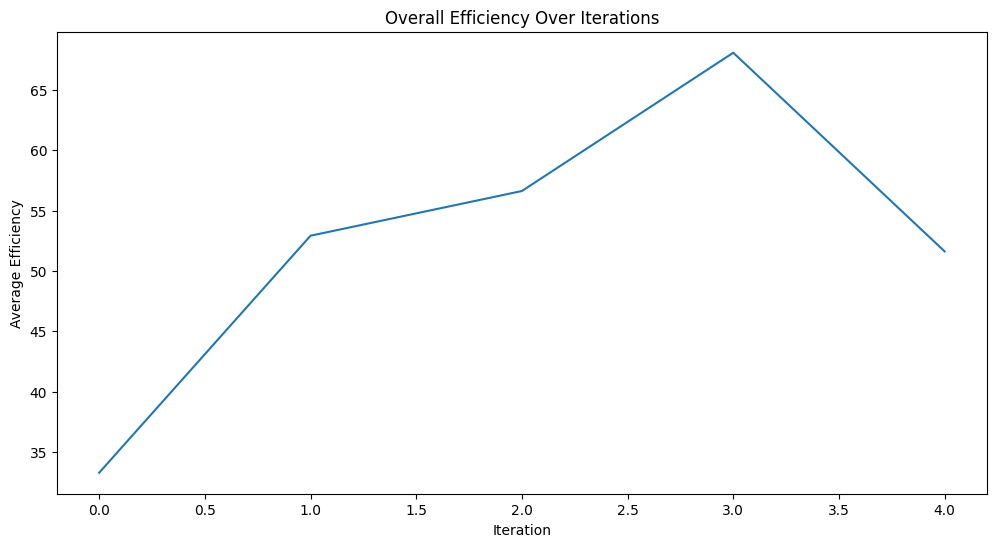

In [40]:
grouped_6 = data_6.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_6)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()